<a href="https://colab.research.google.com/github/omidmno2/stockMarketPrediction_DL/blob/main/AAPL_1d_CNN_LSTM_with_standard_scaler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf

In [3]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [4]:
!pip install yfinance

     |████████████████████████████████| 6.3 MB 15.0 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=e387713668259be2d6e74872963e70a31b9cce15b38a86886029bf4b410a3bbd
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [5]:
from pandas_datareader import data as pdr
import yfinance as yfin
yfin.pdr_override()

In [28]:
import yfinance as yf
daily_data = yf.download(tickers='AAPL', period = '1000wk', interval = '1d')
daily_data

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2002-08-26,0.284821,0.284821,0.270714,0.277321,0.238112,189968800
2002-08-27,0.280536,0.281071,0.262679,0.265179,0.227687,262231200
2002-08-28,0.264286,0.270000,0.261607,0.262500,0.225387,247973600
2002-08-29,0.261607,0.269286,0.259107,0.262500,0.225387,164169600
2002-08-30,0.263036,0.270357,0.260357,0.263393,0.226154,193519200
...,...,...,...,...,...,...
2021-10-19,147.009995,149.169998,146.550003,148.759995,148.759995,76378900
2021-10-20,148.699997,149.750000,148.119995,149.259995,149.259995,58418800
2021-10-21,148.809998,149.639999,147.869995,149.479996,149.479996,61421000


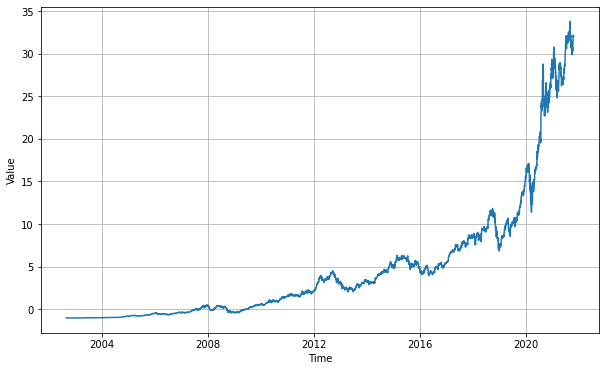

In [30]:
from sklearn.preprocessing import StandardScaler

series = daily_data['Close'].values.reshape(-1, 1)
scaler = StandardScaler()
scaler.fit(series[:len(series) // 2])
series = scaler.transform(series).flatten()

series = np.array(series)
time = np.array(daily_data.index)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [31]:
split_time = 4000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000

In [32]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [33]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [34]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 10
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(learning_rate=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])


<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(4000,)
Epoch 1/100
16/16 [==============================] - 4s 28ms/step - loss: 2.6482 - mae: 3.0579
Epoch 2/100
16/16 [==============================] - 1s 33ms/step - loss: 2.5663 - mae: 2.9919
Epoch 3/100
16/16 [==============================] - 1s 33ms/step - loss: 2.4809 - mae: 2.9228
Epoch 4/100
16/16 [==============================] - 1s 31ms/step - loss: 2.4104 - mae: 2.8626
Epoch 5/100
16/16 [==============================] - 1s 32ms/step - loss: 2.3540 - mae: 2.8117
Epoch 6/100
16/16 [==============================] - 1s 33ms/step - loss: 2.3061 - mae: 2.7665
Epoch 7/100
16/16 [==============================] - 1s 31ms/step - loss: 2.2622 - mae: 2.7244
Epoch 8/100
16/16 [==============================] - 1s 32ms/step - loss: 2.2203 - mae: 2.6830
Epoch 9/100
16/16 [==============================] - 1s 33ms/step - loss: 2.1776 - mae: 2.6399
Epoch 10/100
16/16 [=======================

(1e-08, 0.0001, 0.0, 25.0)

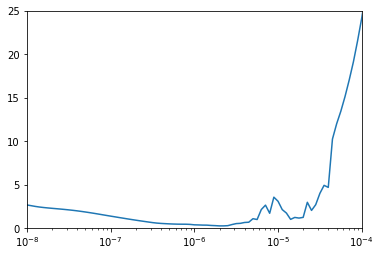

In [36]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 25])

In [38]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(learning_rate=2e-6, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=150)

Epoch 1/150
40/40 [==============================] - 24s 36ms/step - loss: 2.1667 - mae: 2.5792
Epoch 2/150
40/40 [==============================] - 2s 36ms/step - loss: 1.2882 - mae: 1.7228
Epoch 3/150
40/40 [==============================] - 2s 35ms/step - loss: 0.3205 - mae: 0.6641
Epoch 4/150
40/40 [==============================] - 2s 35ms/step - loss: 0.2845 - mae: 0.6163
Epoch 5/150
40/40 [==============================] - 2s 35ms/step - loss: 0.2344 - mae: 0.5607
Epoch 6/150
40/40 [==============================] - 2s 35ms/step - loss: 0.1151 - mae: 0.3629
Epoch 7/150
40/40 [==============================] - 2s 36ms/step - loss: 0.0874 - mae: 0.2944
Epoch 8/150
40/40 [==============================] - 2s 35ms/step - loss: 0.0742 - mae: 0.2624
Epoch 9/150
40/40 [==============================] - 2s 36ms/step - loss: 0.0672 - mae: 0.2429
Epoch 10/150
40/40 [==============================] - 2s 35ms/step - loss: 0.0662 - mae: 0.2468
Epoch 11/150
40/40 [============================

In [39]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

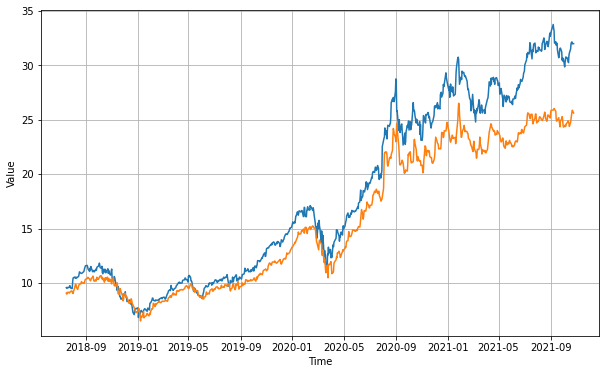

In [40]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

2.9076653

In [ ]:
print(rnn_forecast)

# EXPECTED OUTPUT -- ARRAY OF VALUES IN THE LOW TEENS

[ 1.8615248   1.7424954   1.6254276   1.5828438   1.5096529   1.2573298
  1.0262463   1.0331986   0.9170458   0.85491836  0.80024785  0.74824077
  0.8002536   0.89955854  0.9167741   0.95568514  0.98705095  1.0694323
  1.0905286   1.0947118   1.0764086   1.0222079   0.9827543   1.014646
  1.0832359   1.1294173   1.2006402   1.2447231   1.2763056   1.3129449
  1.3696734   1.4225957   1.4376614   1.451085    1.3964739   1.3505807
  1.3507994   1.333136    1.3088098   1.297214    1.3350991   1.4011832
  1.4018337   1.3683496   1.343937    1.3724538   1.4264511   1.472338
  1.4976425   1.5262094   1.5580019   1.5960584   1.7178046   1.8205835
  1.8426906   1.9088467   1.9203616   1.9193264   1.9374311   1.9852957
  2.096164    2.16221     2.1217124   2.0119026   1.9000998   1.8937011
  1.944038    2.0328455   2.0425076   2.028165    2.0922403   2.127544
  2.1277385   2.0989702   2.0168924   1.9688941   1.9599887   1.8887556
  1.8464599   1.8512491   1.880507    1.9644139   2.0015728   2.03